# Initialise environment

simple analysis of the CAFE60 BGC output - version for the OOD

Looking at how to determine what ensemble members to use in the pre-industrial simulation.  I want 10 members.  
Nic used member 25 and I used the seasonal cycle in the SO to identify member 79.  No I need a few more members.


In [1]:
import xarray as xr
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import numpy as np
#import xrft
import scipy
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
%config Completer.use_jedi = False

from eofs.xarray import Eof

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


# Start Cluster

# non OOD cluster

walltime = '04:00:00'
cores = 2
memory = '8GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory),
                     job_extra=['-l ncpus='+str(cores),'-l mem='+str(memory),
                                '-l storage=gdata/v14+scratch/v14+gdata/lp01+scratch/lp01+scratch/ux06+gdata/rr3+gdata/al33+gdata/zv2+gdata/xv83'],
                     header_skip=["select"])

cluster.scale(jobs=6)
client = Client(cluster)
client

#
client.shutdown()
cluster.shutdown()

In [2]:
# in the OOD cluster

from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,processes=1,memory="47GB",walltime='02:00:00')
client = Client(cluster)
cluster.scale(cores=48)

In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.131:45835,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Read in data

and create useful variables for further calculations 

In [5]:
def climatology(dsx,TIME1):
    clim = dsx.groupby(TIME1+'.month').mean(dim=TIME1)
    anom = dsx.groupby(TIME1+'.month') - clim
    season=dsx.groupby(TIME1+'.season').mean(dim=TIME1)
    return(clim,season,anom)

In [6]:
file1='/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip'
file2='/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip'
file4='/g/data/xv83/dcfp/CAFE60v1/ocean_daily.zarr.zip'
file3='/home/mat236/area.nc'

#dgrid=xr.open_dataset(file1)
docn = xr.open_zarr(file1,consolidated=True)
darea= xr.open_dataset('/g/data/xv83/rxm599/area.nc')
#darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
darea

dbgc = xr.open_zarr(file2)

In [7]:

darea= xr.open_dataset('/g/data/xv83/rxm599/grid_spec_dyn.nc')
darea

<xarray.Dataset>
Dimensions:        (zt: 50, zb: 50, grid_x_T: 360, grid_y_T: 300,
                    grid_x_C: 360, grid_y_C: 300, vertex: 4, i_atmXocn: 111817,
                    i_atmXlnd: 5285, i_lndXocn: 111817, xba: 145, yba: 91,
                    xta: 144, yta: 90, xbl: 145, ybl: 91, xtl: 144, ytl: 90,
                    xto: 360, yto: 300, time: 1, yt: 300, xt: 360)
Coordinates: (12/20)
  * zt             (zt) float32 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * zb             (zb) float32 10.0 20.0 30.0 ... 5.333e+03 5.665e+03 6e+03
  * grid_x_T       (grid_x_T) float32 -279.5 -278.5 -277.5 ... 77.5 78.5 79.5
  * grid_y_T       (grid_y_T) float32 -77.88 -77.63 -77.38 ... 88.87 89.32 89.77
  * grid_x_C       (grid_x_C) float32 -279.0 -278.0 -277.0 ... 78.0 79.0 80.0
  * grid_y_C       (grid_y_C) float32 -77.75 -77.51 -77.26 ... 89.1 89.55 90.0
    ...             ...
  * ytl            (ytl) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * xto            (xto) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * yto            (yto) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
  * time           (time) object 2009-03-18 12:00:00
  * xt             (xt) float64 -279.5 -278.6 -277.6 ... 77.65 78.59 79.53
  * yt             (yt) float64 -77.88 -77.63 -77.38 ... 78.71 78.78 78.82
Dimensions without coordinates: i_atmXocn, i_atmXlnd, i_lndXocn
Data variables: (12/125)
    x_T            (grid_y_T, grid_x_T) float64 ...
    y_T            (grid_y_T, grid_x_T) float64 ...
    x_vert_T       (vertex, grid_y_T, grid_x_T) float64 ...
    y_vert_T       (vertex, grid_y_T, grid_x_T) float64 ...
    area_T         (grid_y_T, grid_x_T) float64 ...
    angle_T        (grid_y_T, grid_x_T) float64 ...
    ...             ...
    J_OCN_LNDxOCN  (i_lndXocn) int32 ...
    AREA_ATM       (yta, xta) float64 ...
    AREA_LND       (ytl, xtl) float64 ...
    AREA_LND_CELL  (ytl, xtl) float64 ...
    AREA_OCN       (yto, xto) float64 ...
    EXT            (time, yt, xt) float32 ...
Attributes: (12/22)
    filename:                  ice_daily_2009_03_15.nc
    xname:                     longitude
    yname:                     latitude
    vertex_convention:         SWCCW
    join_lat:                  65.0
    y_boundary_type:           fold_north_edge
    ...                        ...
    title:                     AccessOcean-AM2
    grid_type:                 regular
    grid_tile:                 N/A
    history:                   Wed Jan 16 15:50:28 2019: ncap2 -A -s where (E...
    nco_openmp_thread_number:  1
    NCO:                       4.3.2

In [8]:
docn

,Array,Chunk
Bytes,1.38 TiB,118.65 MiB
Shape,"(731, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12428 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.38 TiB,118.65 MiB
Shape,"(731, 96, 50, 300, 360)","(1, 96, 3, 300, 360)"
Count,12428 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [9]:
# create a thickness variable on the tracer depth grid
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
#print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth

<xarray.DataArray 'st_ocean' (st_ocean: 50)>
array([ 10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.        ,  10.        ,  10.        ,  10.        ,
        10.92337036,  18.17451477,  31.96699524,  50.95071411,
        73.26739502,  96.73260498, 119.04928589, 138.03302002,
       151.82550049, 159.07659912, 160.26977539, 162.41760254,
       166.66052246, 172.89404297, 180.96447754, 190.67321777,
       201.78149414, 214.01513672, 227.07348633, 240.63476562,
       254.36523438, 267.92651367, 280.98486328, 293.21850586,
       304.3269043 , 314.03515625, 322.10644531, 328.33935547,
       332.58203125, 334.73046875])
Coordinates:
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03

# Anthropogenic CO2 flux

In [52]:
ens=24
t1 = '2000-01-01'
t2 = '2019-12-31'
x1=-240 ; x2=-60
y1=-5 ; y2=5
totd=dbgc.stf10[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
natd=dbgc.stf07[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
totd.shape

(240, 30, 180)

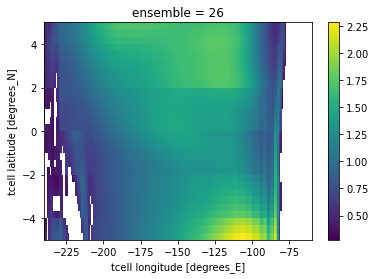

In [11]:
tota = (totd-natd).compute()
(tota.mean(axis=0)*86400).plot()

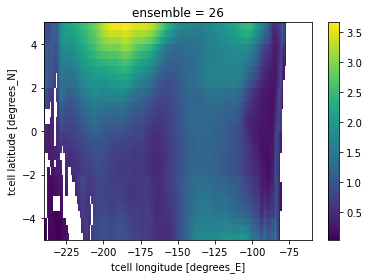

In [12]:
(tota.sel(time=slice('2015-12-01','2016-03-16')).mean(axis=0)*86400).plot()

In [13]:
# total flux into ocean

area_r=darea.area_T.rename({'grid_y_T':'yt_ocean','grid_x_T':'xt_ocean' })
area_s = area_r.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area_tmp=area_s.assign_coords({'yt_ocean': tota.yt_ocean}).load()
tflux_aco2 = (tota.mean(axis=0)*86400*365)*area_tmp.compute()

iflux=tflux_aco2.sum(axis=(0,1))*12e-15*1e-3  # mmol C/y to PgC/y
print(iflux.values, (iflux*20).values)

0.10126559571387077 2.0253119142774154


Comment
average uptake per year and uptake over 20 years is

0.062 and 1.24

In [14]:
#mkdir richard_calcs#  write output

In [15]:
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'
tflux_aco2.to_netcdf(direc+'eq_aco2flux.nc')

# Anthropogenic CO2 concentration

In [53]:
ens=24
t1 = '2000-01-01'
t2 = '2019-12-31'
x1=-240 ; x2=-60
y1=-5 ; y2=5

adic=dbgc.adic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
dic=dbgc.dic[:,ens,:,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
aco2=adic-dic

aco2.nbytes*1e-6


259.2

In [17]:

cthickness=mdepth
cthickness
omask=(aco2[-1,0,:,:]*0).copy()
cinv = aco2*cthickness*1e-3 #mmol to mols

mcinv600=cinv.sel(st_ocean=slice(0,600)).sum(axis=1)+omask
mcinv300=cinv.sel(st_ocean=slice(0,300)).sum(axis=1)+omask
mcinv1000=cinv.sel(st_ocean=slice(0,1000)).sum(axis=1)+omask
mcinv=cinv.sum(axis=1)+omask

# difference between end and start
aco2_c300 = (mcinv300[-1:,:,:]-mcinv300[0,:,:])
aco2_call = (mcinv[-1:,:,:]-mcinv[0,:,:])

# integrate multiple by grid cell area
area_r=darea.area_T.rename({'grid_y_T':'yt_ocean','grid_x_T':'xt_ocean' })
area_s = area_r.sel(xt_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
area_tmp=area_s.assign_coords({'yt_ocean': aco2.yt_ocean}).load()
i_aco2_300=aco2_c300*area_tmp 
i_aco2_all=aco2_call*area_tmp 

# equatorial Pacific
# 160E  and 110W  - -200 and -110
x1e=-227 ; x2e=-75
y1e=-3 ; y2e=3
tmp1=i_aco2_300.sel(xt_ocean=slice(x1e,x2e),yt_ocean=slice(y1e,y2e)).compute()
tmp2=i_aco2_all.sel(xt_ocean=slice(x1e,x2e),yt_ocean=slice(y1e,y2e)).compute()

sum1=tmp1.sum(axis=(1,2))*12*1e-15 #Pg C
sum=tmp2.sum(axis=(1,2))*12*1e-15 #Pg C

print(sum.values,sum1.values)

[0.99998058] [0.69722179]


In [18]:

tmp1.to_netcdf(direc+'eq_iaco2_300.nc')
tmp2.to_netcdf(direc+'eq_iaco2_all.nc')

Text(0.5, 1.0, 'total')

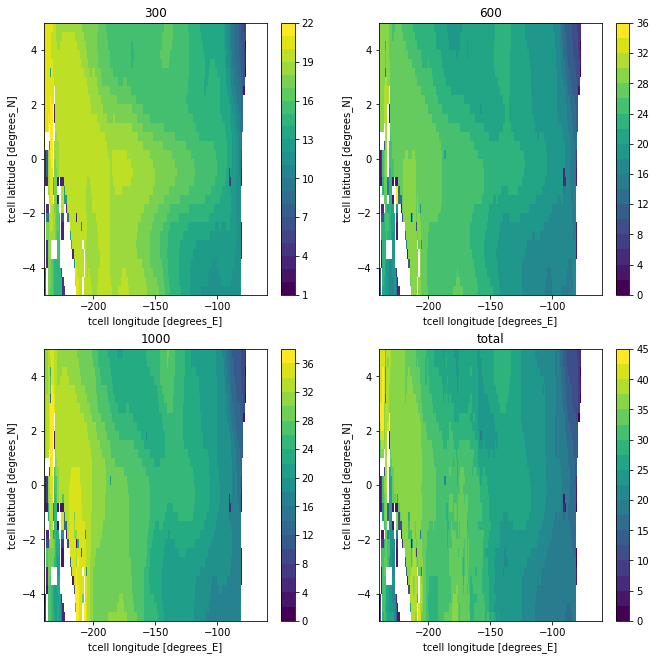

In [19]:
plt.figure(figsize=(11,11))
plt.subplot(2,2,1)
mcinv300[-1,:,:].plot(levels=21)
plt.title('300')
plt.subplot(2,2,2)
mcinv600[-1,:,:].plot(levels=21)
plt.title('600')
plt.subplot(2,2,3)
mcinv1000[-1,:,:].plot(levels=21)
plt.title('1000')
plt.subplot(2,2,4)
mcinv[-1,:,:].plot(levels=21)
plt.title('total')

The numbers give the total inventory in tropical pacific (3N - 3S) in PgC 

for entire ocean 0.7 PgC 
for upper 300 m 0.6 PgC 


End of calculations with aco2 and fluxes

# Plot aco2 concentrations on a few zonal sections

Text(0.5, 1.0, '-190W')

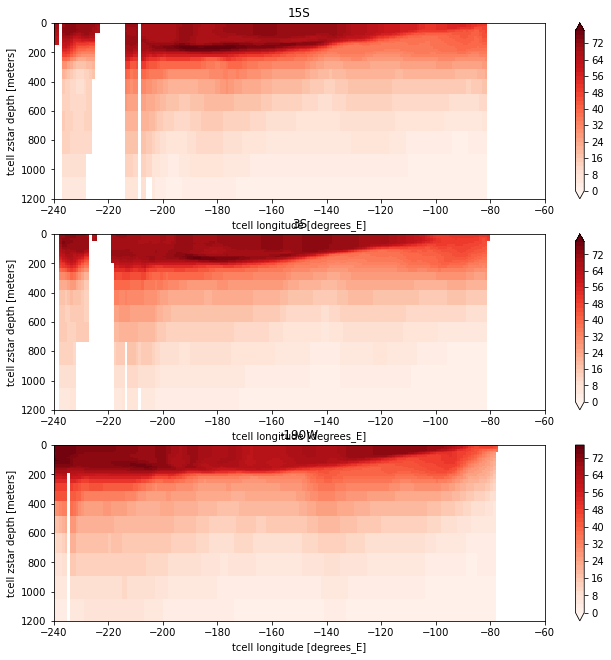

In [20]:

plt.figure(figsize=(11,11))
plt.subplot(3,1,1)
aa=aco2[-1:,:,:,:].sel(yt_ocean=-15,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('15S')

plt.subplot(3,1,2)
aa=aco2[-1:,:,:,:].sel(yt_ocean=-3,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('3S')

plt.subplot(3,1,3)
aa=aco2[-1:,:,:,:].sel(yt_ocean=3,method='nearest')
aa.sel(st_ocean=slice(0,4000)).plot(yincrease=False,ylim=[1200,0],levels=np.arange(0,80,2),cmap='Reds')#,title='Lat=3S')
plt.title('-190W')

# Transport

In [21]:
print(cluster)

SLURMCluster(d7d94d24, 'tcp://10.0.128.131:45835', workers=15, threads=30, memory=656.55 GiB)


In [22]:
print(client)

<Client: 'tcp://10.0.128.131:45835' processes=15 threads=30, memory=656.55 GiB>


In [54]:

ens=24
t1 = '2000-01-01'
t2 = '2019-12-31'
x1=-240 ; x2=-60
y1=-5 ; y2=5
vt=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2)).sel(yu_ocean=y1,method='nearest')

tv=docn.ty_trans[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
tv_gm_i=docn.ty_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xt_ocean=slice(x1,x2),yu_ocean=slice(y1,y2))
tu=docn.tx_trans[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))
tu_gm_i=docn.tx_trans_gm[:,ens,:,:].sel(time=slice(t1,t2),xu_ocean=slice(x1,x2),yt_ocean=slice(y1,y2))


In [24]:
tmp=docn.ty_trans_gm[0,ens,:,:]
tmp

<xarray.DataArray 'ty_trans_gm' (st_ocean: 50, yu_ocean: 300, xt_ocean: 360)>
dask.array<getitem, shape=(50, 300, 360), dtype=float32, chunksize=(3, 300, 360), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 26
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    time      object 1960-01-16 12:00:00
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
Attributes:
    cell_methods:  time: mean
    long_name:     T-cell mass j-transport from GM
    units:         Sv (10^9 kg/s)
    valid_range:   [-1.0000000200408773e+20, 1.0000000200408773e+20]

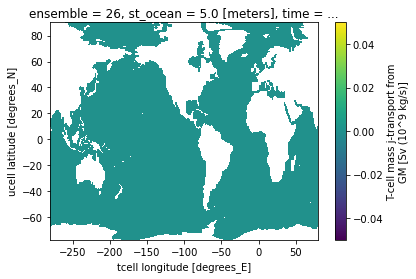

In [25]:
#from xgcm import Grid
tmp[0,:,:].plot()

In [26]:
tv_gm=tv_gm_i-tv_gm_i.shift(st_ocean=-1)

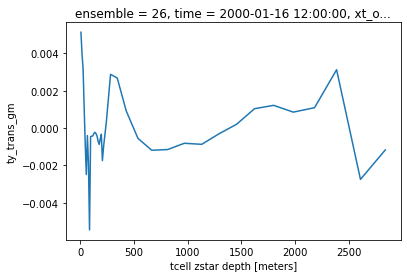

In [27]:
tv_gm[0,:,0,75].plot()

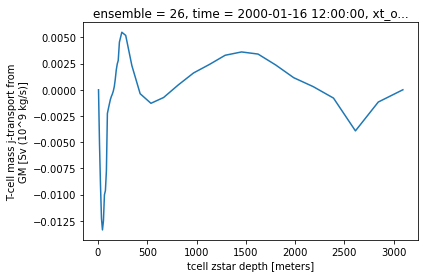

In [28]:
tv_gm_i[0,:,0,75].plot()

In [55]:
# need to rename axis to work !! aco2_face=aco2.interp_like(tv)
aco2_face=aco2.interp(yt_ocean=tv.yu_ocean)

aco2_face

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,74194 Tasks,4080 Chunks
Type,float32,numpy.ndarray


In [56]:
trans_aco2 = aco2_face*tv
trans_aco2_gm = aco2_face*tv_gm

In [57]:
# CALC TU AS WELL AS TV

tu_gm=tu_gm_i-tu_gm_i.shift(st_ocean=-1)
aco2_face_u=aco2.interp(xt_ocean=tu.xu_ocean)
trans_aco2_u = aco2_face_u*tu
trans_aco2_u_gm = aco2_face_u*tu_gm

In [49]:
tu_gm

In [59]:
direc='/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/richard_calcs/'

tv.to_netcdf(direc+'trans_v.nc')
trans_aco2.to_netcdf(direc+'trans_aco2_v.nc')
trans_aco2_gm.to_netcdf(direc+'trans_aco2_v_gm.nc')

tu.to_netcdf(direc+'trans_u.nc')
trans_aco2_u.to_netcdf(direc+'trans_aco2_u.nc')
trans_aco2_u_gm.to_netcdf(direc+'trans_aco2_u_gm.nc')


#trans_aco2.to_netcdf(direc+'trans_aco2.nc')
#trans_aco2.to_netcdf(direc+'trans.nc')
#trans_aco2_gm.to_netcdf(direc+'trans_aco2_gm.nc')


In [58]:
tv

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,28935 Tasks,4080 Chunks
Type,float32,numpy.ndarray


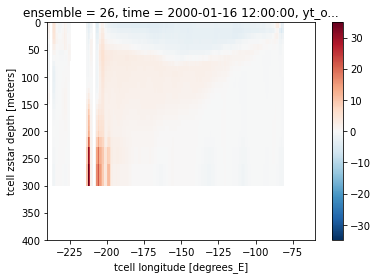

In [31]:
trans_aco2[0,0:24,0,:].plot(ylim=[400,0])

In [32]:
trans_aco2_gm

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,131690 Tasks,4080 Chunks
Type,float32,numpy.ndarray


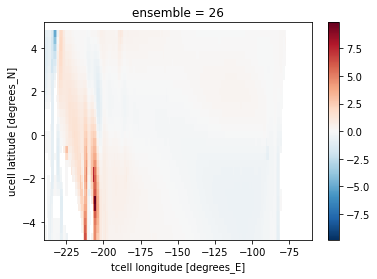

In [33]:
trans_aco2.mean(['time','st_ocean']).plot()

In [34]:
tv

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,28935 Tasks,4080 Chunks
Type,float32,numpy.ndarray


In [35]:
trans_aco2[:,0:24,0,:]#.sum(axis=(1,2))

,Array,Chunk
Bytes,3.96 MiB,2.11 kiB
Shape,"(240, 24, 180)","(1, 3, 180)"
Count,109129 Tasks,1920 Chunks
Type,float32,numpy.ndarray


In [ ]:
trans_s_gm_300=trans_aco2_gm[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n_gm_300=trans_aco2_gm[:,0:24,17,:].sum(axis=(1,2)).compute()
trans_s_300=trans_aco2[:,0:24,0,:].sum(axis=(1,2)).compute()
trans_n_300=trans_aco2[:,0:24,17,:].sum(axis=(1,2)).compute()

mtrans_s_300=tv[:,0:24,0,:].sum(axis=(1,2)).compute()
mtrans_n_300=tv[:,0:24,17,:].sum(axis=(1,2)).compute()

## 

In [36]:
tv

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,28935 Tasks,4080 Chunks
Type,float32,numpy.ndarray


ERROR! Session/line number was not unique in database. History logging moved to new session 2818


In [38]:
#trans_aco2.to_netcdf(direc+'trans_aco2.nc')
#trans_aco2.to_netcdf(direc+'trans.nc')
trans_aco2_gm.to_netcdf(direc+'trans_aco2_gm.nc')


In [50]:
tv

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,28935 Tasks,4080 Chunks
Type,float32,numpy.ndarray


In [ ]:
trans_s_gm
trans_n_gm
trans_s
trans_n
mtrans_s
mtrans_n

In [49]:
trans_s

<xarray.DataArray (time: 240)>
array([ 1.45735083e+03,  1.85537158e+03,  2.02840271e+03,  1.76400427e+03,
        2.77422821e+02, -6.14111816e+02, -9.27494263e+02, -7.80365540e+02,
       -4.25940216e+02,  2.51414246e+02,  2.41942139e+02,  1.04902258e+03,
        8.92483337e+02,  1.88208447e+03,  2.26582764e+03,  1.53863330e+03,
        2.28735123e+02, -1.11674817e+03, -6.91054138e+02, -5.35020752e+02,
        9.20824661e+01,  2.35911148e+02,  3.71733612e+02,  3.28529243e+01,
        1.17631482e+03,  1.42368335e+03,  2.20708447e+03,  1.88428137e+03,
        6.65491028e+01, -1.07751562e+03, -1.11039636e+03,  3.81295264e-01,
        4.87758217e+01,  1.21227394e+02,  5.86737549e+02,  3.02044067e+02,
        4.27191895e+02,  1.53906470e+03,  2.19502881e+03,  1.72286292e+03,
        1.24322766e+03,  4.58511925e+01, -2.00250275e+02, -7.77957886e+02,
        9.25102005e+01,  5.24386780e+02,  7.50614990e+02,  6.84253662e+02,
        6.67003784e+02,  1.24970581e+03,  2.07633325e+03,  1.88776367e+03,
        7.30277039e+02, -7.12380615e+02, -7.56637024e+02, -3.86487701e+02,
        2.87651031e+02,  5.55367737e+02,  3.88511475e+02,  5.25118652e+02,
        8.55136169e+02,  2.05196289e+03,  1.07073242e+03,  1.68926904e+03,
        4.55646027e+02, -6.14266357e+02, -1.03834009e+03, -4.11254700e+02,
       -1.48256439e+02,  4.19741608e+02,  5.59970520e+02,  2.00645538e+02,
        1.25088452e+03,  1.97561658e+03,  1.86870056e+03,  1.69071606e+03,
        4.84241882e+02, -5.33510071e+02, -5.47726807e+02, -9.43196350e+02,
...
       -5.60313049e+02, -1.34884552e+02,  2.43269974e+02,  3.84834778e+02,
        9.30486633e+02,  2.11234692e+03,  2.65086621e+03,  1.13129565e+03,
       -6.27544373e+02, -1.44773889e+03, -1.87315112e+03, -6.07866577e+02,
       -1.17640271e+03, -1.60810883e+02,  8.20722473e+02,  6.69455139e+02,
        1.08956689e+03,  2.52020801e+03,  2.36133911e+03,  1.43902661e+03,
       -7.45892578e+02, -8.33323181e+02, -1.95636169e+03, -1.20171765e+03,
       -1.03371216e+03,  5.70506592e+02,  4.37078552e+02,  4.55127167e+02,
        1.11426001e+03,  2.36242920e+03,  2.38849878e+03,  1.64414124e+03,
        1.18148865e+02, -3.16108673e+02, -2.91400635e+02, -8.38137634e+02,
       -4.70399506e+02,  8.13334167e+02,  1.00347534e+03,  8.49297180e+02,
        1.02075250e+03,  2.23974316e+03,  2.58569409e+03,  2.31805981e+03,
        4.81864502e+02, -1.10491479e+03, -1.91746484e+03, -1.33220679e+03,
       -1.06018054e+03,  8.35732422e+02,  5.04824921e+02,  4.63593109e+02,
        1.22697046e+03,  2.41812231e+03,  3.14218481e+03,  1.81025244e+03,
        2.22282532e+02, -9.17053162e+02, -1.24289600e+03, -1.62142700e+03,
       -6.00981873e+02,  9.04482483e+02,  7.35194092e+02, -1.01017395e+02,
        7.31192871e+02,  1.91100916e+03,  2.63341064e+03,  1.87548706e+03,
        2.09995514e+02, -6.14854309e+02, -3.77186279e+02, -1.24075378e+03,
       -2.11393692e+02,  8.84939194e+01,  7.55379028e+02,  3.47491028e+02],
      dtype=float32)
Coordinates:
    ensemble  int32 26
  * time      (time) object 2000-01-16 12:00:00 ... 2019-12-16 12:00:00
    yt_ocean  float64 -4.667
    yu_ocean  float64 -4.667

## 

In [37]:
trans_s_gm=trans_aco2_gm[:,:,0,:].sum(axis=(1,2)).compute()
trans_n_gm=trans_aco2_gm[:,:,17,:].sum(axis=(1,2)).compute()
trans_s=trans_aco2[:,:,0,:].sum(axis=(1,2)).compute()
trans_n=trans_aco2[:,:,17,:].sum(axis=(1,2)).compute()

mtrans_s=tv[:,:,0,:].sum(axis=(1,2)).compute()
mtrans_n=tv[:,:,17,:].sum(axis=(1,2)).compute()



In [38]:
print(trans_s_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_s_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_gm_300.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

print(mtrans_s_300.mean(axis=0).values )
print(mtrans_n_300.mean(axis=0).values )

0.0657306807451172
-0.005238604016235352
0.241178704875
-0.0036998977055053713
1.6358877
10.885732


In [39]:
print(trans_s.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_s_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)
print(trans_n_gm.mean(axis=0).values * 1e6 *1e-15*12*1e-3 * 86400 *365)

print(mtrans_s.mean(axis=0).values )
print(mtrans_n.mean(axis=0).values )

0.17194982057226563
-0.004083869894897461
0.2604513661523438
-0.0024534792421875007
10.474433
10.02864


The transport across the 3S and 3N for anthropogenic CO2 and mass.  The aco2 is separated into eulerian and gm



In [40]:
tv_gm

,Array,Chunk
Bytes,247.19 MiB,63.28 kiB
Shape,"(240, 50, 30, 180)","(1, 3, 30, 180)"
Count,53416 Tasks,4080 Chunks
Type,float32,numpy.ndarray


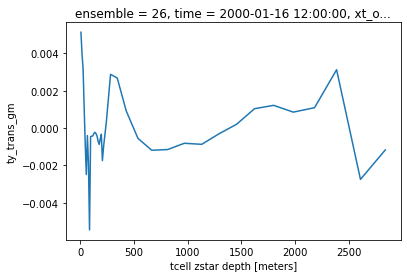

In [41]:
tv_gm[0,:,0,75].plot()

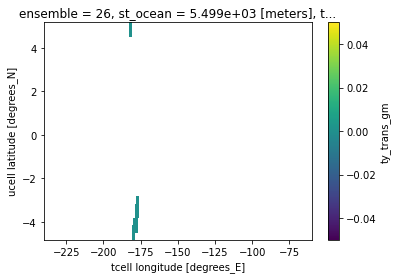

In [42]:
tv_gm[0,48,:,:].plot()